In [1]:
import pandas as pd

# Read the file
file_path = 'output_results_small.txt'
with open(file_path, 'r') as file:
    lines = file.readlines()

data = []
current_graph = {}
current_algorithm = None
current_threads = None

# Process each line
for line in lines:
    line = line.strip()
    if 'Graph Type:' in line:
        current_graph = {'Graph Type': line.split(':')[-1].strip()}  # Start new graph block
    elif 'Vertices:' in line:
        current_graph['Vertices'] = int(line.split(':')[-1].strip())
    elif 'Edges:' in line:
        current_graph['Edges'] = int(line.split(':')[-1].strip())
    elif 'Min Weight:' in line:
        current_graph['Min Weight'] = int(line.split(':')[-1].strip())
    elif 'Max Weight:' in line:
        current_graph['Max Weight'] = int(line.split(':')[-1].strip())
    elif 'Delta:' in line:
        current_graph['Delta'] = float(line.split(':')[-1].strip())
    elif 'Algorithm:' in line:
        current_algorithm = line.split(':')[-1].strip()
        # Reset threads for non-parallel algorithms
        current_threads = None
    elif 'Threads:' in line:
        current_threads = int(line.split(':')[-1].strip())
    elif 'Time:' in line:
        time = float(line.split(':')[-1].strip().replace('ms', '').strip())
        entry = current_graph.copy()
        entry.update({
            'Algorithm': current_algorithm,
            'Threads': current_threads,
            'Time': time
        })
        data.append(entry)

# Create DataFrame from collected data
df = pd.DataFrame(data)


df = df[df['Algorithm'].str.contains("Sequential|Parallel")]
sequential_best = df[df['Algorithm'].str.contains("Sequential")].groupby(['Graph Type', 'Vertices', 'Edges', 'Min Weight', 'Max Weight', 'Delta'], as_index=False).Time.min()
df = df.merge(sequential_best, on=['Graph Type', 'Vertices', 'Edges', 'Min Weight', 'Max Weight', 'Delta'], suffixes=('', '_best_seq'))
df['better_than_sequential'] = df['Time'] < df['Time_best_seq']
df['threads_improvement'] = df.groupby(['Graph Type', 'Vertices', 'Algorithm'])['Time'].shift(1) > df['Time']
df_better_than_sequential = df[df['better_than_sequential']]
df_relevant_cases = df_better_than_sequential[['Graph Type', 'Vertices', 'Edges', 'Min Weight', 'Max Weight', 'Delta', 'Algorithm', 'Threads', 'Time', 'Time_best_seq', 'better_than_sequential', 'threads_improvement']]
df_relevant_cases = df_relevant_cases.sort_values(['Graph Type', 'Vertices', 'Edges'])

print(df_relevant_cases)

# Save to CSV
csv_file_path = 'algorithm_performance_parsed.csv'
df.to_csv(csv_file_path, index=False)

#df.head(545), csv_file_path


    Graph Type  Vertices  Edges  Min Weight  Max Weight  Delta  \
189       grid       200   1000           1           5    1.0   
191       grid       200   1000           1           5    1.0   
245       grid       200   1000           1          10    3.0   
247       grid       200   1000           1          10    3.0   
249       grid       200   1000           1          10    3.0   
251       grid       200   1000           1          10    3.0   
455       grid       500   2500           1           5    3.0   
457       grid       500   2500           1           5    3.0   
459       grid       500   2500           1           5    3.0   
466       grid       500   2500           1          10    1.0   
467       grid       500   2500           1          10    1.0   
468       grid       500   2500           1          10    1.0   
469       grid       500   2500           1          10    1.0   

                               Algorithm  Threads     Time  Time_best_seq  

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load your CSV data
df_parsed = pd.read_csv('algorithm_performance_parsed.csv')


In [3]:
# Ensure 'Threads' is filled with appropriate values for plotting
df['Threads'].fillna(1.0, inplace=True)


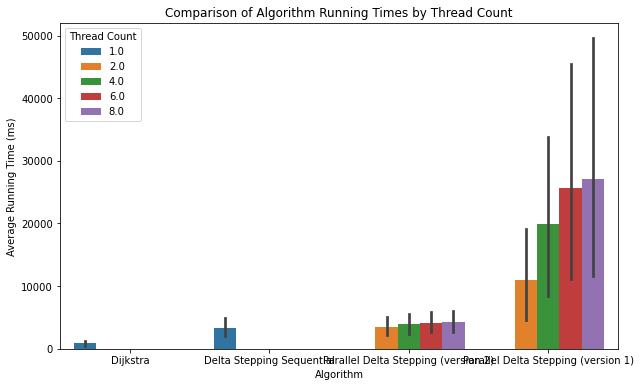

In [4]:
# Bar chart comparing mean running times of each algorithm
plt.figure(figsize=(10, 6))
sns.barplot(x='Algorithm', y='Time', hue='Threads', data=df)
plt.title('Comparison of Algorithm Running Times by Thread Count')
plt.ylabel('Average Running Time (ms)')
plt.xlabel('Algorithm')
plt.legend(title='Thread Count')
plt.show()


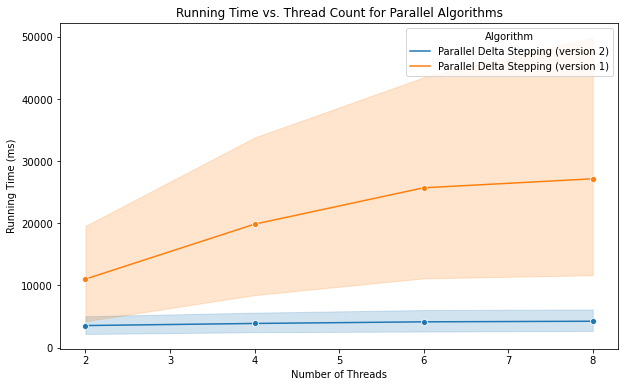

In [5]:
# Filter to include only parallel delta stepping algorithm
parallel_data = df[df['Algorithm'].str.contains('Parallel')]

plt.figure(figsize=(10, 6))
sns.lineplot(x='Threads', y='Time', hue='Algorithm', data=parallel_data, marker='o')
plt.title('Running Time vs. Thread Count for Parallel Algorithms')
plt.ylabel('Running Time (ms)')
plt.xlabel('Number of Threads')
plt.legend(title='Algorithm')
plt.show()


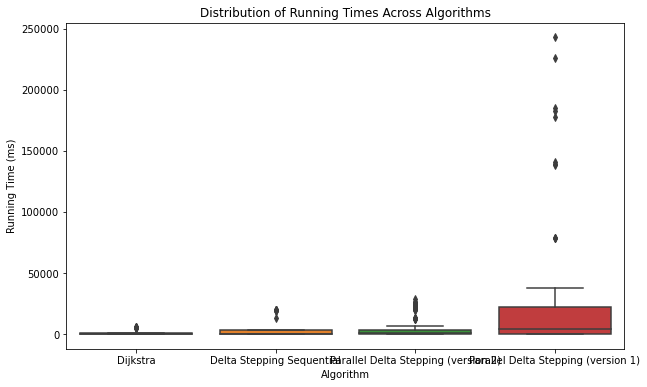

In [6]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Algorithm', y='Time', data=df)
plt.title('Distribution of Running Times Across Algorithms')
plt.ylabel('Running Time (ms)')
plt.xlabel('Algorithm')
plt.show()


In [7]:

# Filter for only dense graphs
dense_df = df_parsed[df_parsed['Graph Type'] == 'grid']
# Check and convert data types if necessary
dense_df['Vertices'] = dense_df['Vertices'].astype(int)
dense_df['Time'] = dense_df['Time'].astype(float)


/var/folders/r4/bvbx_13n1gb9rw83vqd167900000gn/T/ipykernel_14932/1118885771.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dense_df['Vertices'] = dense_df['Vertices'].astype(int)
/var/folders/r4/bvbx_13n1gb9rw83vqd167900000gn/T/ipykernel_14932/1118885771.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dense_df['Time'] = dense_df['Time'].astype(float)


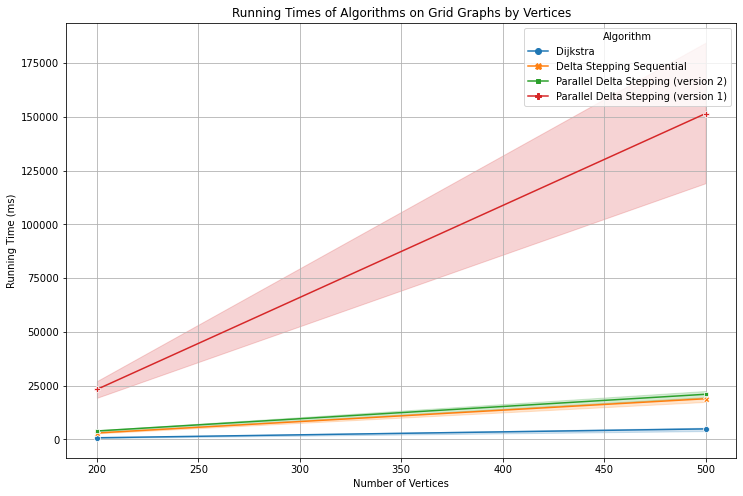

In [8]:
plt.figure(figsize=(12, 8))
sns.lineplot(x='Vertices', y='Time', hue='Algorithm', style='Algorithm', markers=True, dashes=False, data=dense_df)
plt.title('Running Times of Algorithms on Grid Graphs by Vertices')
plt.xlabel('Number of Vertices')
plt.ylabel('Running Time (ms)')
plt.legend(title='Algorithm')
plt.grid(True)
plt.show()


In [9]:
# Filter for parallel and sequential delta stepping
seq_df = df[df['Algorithm'] == 'Delta Stepping Sequential']
par_df = df[df['Algorithm'].str.contains('Parallel')]

# Find the minimum running time for parallel version per graph type and number of vertices
min_par_time = par_df.groupby(['Graph Type', 'Vertices', 'Delta', 'Min Weight', 'Max Weight'])['Time'].min().reset_index()
min_par_time.rename(columns={'Time': 'Min Parallel Time'}, inplace=True)

# Merge this minimum time with the sequential times
comparison_df = pd.merge(seq_df, min_par_time, on=['Graph Type', 'Vertices', 'Delta', 'Min Weight', 'Max Weight'])

# Calculate the time difference
comparison_df['Time Difference'] = comparison_df['Min Parallel Time'] - comparison_df['Time'] 

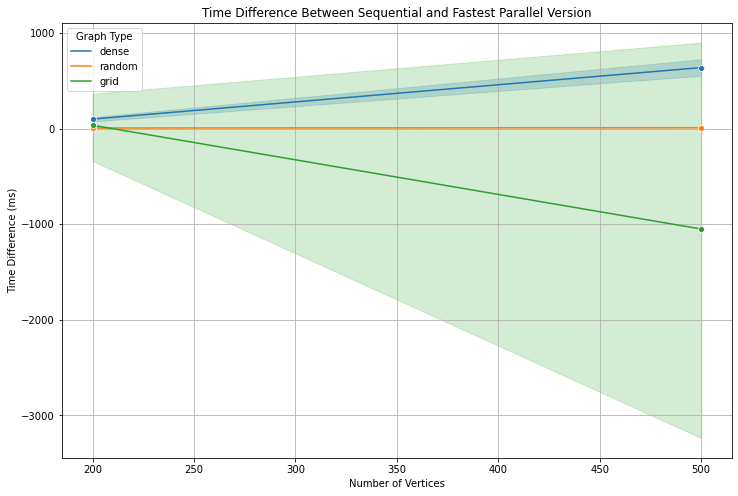

In [10]:
plt.figure(figsize=(12, 8))
sns.lineplot(data=comparison_df, x='Vertices', y='Time Difference', hue='Graph Type', marker='o')
plt.title('Time Difference Between Sequential and Fastest Parallel Version')
plt.xlabel('Number of Vertices')
plt.ylabel('Time Difference (ms)')
plt.legend(title='Graph Type')
plt.grid(True)
plt.show()
